# RIVM Summer School - Agent Based Modeling with Mesa

"[Mesa](https://mesa.readthedocs.io/en/stable/index.html) is an agent-based modeling framework in Python. Mesa allows users to quickly create agent-based models using built-in core components (such as spatial grids and agent schedulers) or customized implementations, visualize them using a browser-based interface, and analyze their results using Python’s data analysis tools."

_This notebook is based on and uses parts of texts from the Mesa docs._

### Discretised Lotka Volterra
In this notebook we aim to familiarise you with Mesa and its Object Oriented Programming approach to Agent-Based Models (ABMs). This will be done through implementation of a simplified preditor-prey model (discretised Lotka Volterra). 

- **If you are not yet comfortable with Object Oriented Programming or need a refresher, please visit [this page](https://python.swaroopch.com/oop.html)**
- **It also might be handy to read the MESA documentation which you can find [here](https://mesa.readthedocs.io/en/stable/)**

We will create a version of the "sheep-wolf" model wherein wolves and sheep wander randomly around the landscape. To allow the population to grow, each wolf or sheep has a fixed probability of reproducing at each timestep. In this simplified version, sheep do not have to eat, and only die when eaten by a wolf. Wolves, however, have a probability of dying. This produces interesting population dynamics, but creates a model that is ultimately unstable.

To do this we need the following:
- **Agents:** the predators and preys
- **Environment:** an area in which the predators and prey can move around and interact
- **Model:** the controller that links the environment and the agents

We've already implemented some parts of the model and the environment is already implemented by Mesa, but it is up to you to implement the Agents!

In [12]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from mesa import Model, Agent
import matplotlib.pyplot as plt
from mesa.space import MultiGrid

from IPython.display import clear_output
clear_output(wait=True)
print("Everything imported!")

Everything imported!


### Testing
Since testing each of the methods that you will create seperately might be difficult, we provide you with a very minimal model that will be used during the testing phase. Later in this notebook we will introduce you to the model that has been implemented in `model.py`.

In [13]:
class TestModel(Model):
    def __init__(self, width, height):
        super().__init__()
        self.height = width
        self.width = height
        
        self.grid = MultiGrid(self.width, self.height, torus=True)
        
        self.n_agents = 0
        self.agents_list = []

    
    def new_agent(self, agent_type, pos):
        '''
        Method that enables us to add agents of a given type.
        '''
        self.n_agents += 1
        
        # Create a new agent of the given type
        new_agent = agent_type(self.n_agents, self)
        
        # Place the agent on the grid
        self.grid.place_agent(new_agent, pos=pos)

        # And add the agent to the model so we can track it
        self.agents_list.append(new_agent)
        
    def remove_agent(self, agent):
        '''
        Method that enables us to remove passed agents.
        '''
        self.n_agents -= 1
        
        # Remove agent from grid
        self.grid.remove_agent(agent)
        
        # Remove agent from model
        self.agents_list.remove(agent)
        
    def step(self):
        '''
        Method that steps every agent. 
        
        Prevents applying step on new agents by creating a local list.
        '''
        for agent in list(self.agents_list):
            print(f'Stepping Agent {agent.unique_id} with position {agent.pos}')
            agent.step()

### Agents - Random walker
As both the sheep and the wolves will walk around randomly, we will first implement a `RandomWalker` class. We can then re-use (inherit) this class when making our `Wolf` and `Sheep` classes. Below you can find the framework for the class, but you will have to implement the `random_move()` method. This method should get the neighbouring cells (Moore's neighbourhood), select one, and move the agent to this cell.

Find the following functions through the provided link and find out which inputs they need:
 - [`MultiGrid.get_neighborhood()`](https://mesa.readthedocs.io/en/stable/apis/space.html#mesa.space.MultiGrid.get_neighborhood)
 - [`MultiGrid.move_agent()`](https://mesa.readthedocs.io/en/stable/apis/space.html#mesa.space.MultiGrid.move_agent)
 
Keep in mind that the `model` that is passed when the RandomWalker is initialised contains the grid. It is accessable through `self.model.grid` in the `random_move` function. 

In [14]:
class RandomWalker(Agent):
    def __init__(self, unique_id, model):
        # Pass the parameters to the parent class.
        super().__init__(unique_id, model)

    def random_move(self):
        ''' 
        This method should get the neighbouring cells (Moore's neighbourhood), select one, and move the agent to this cell.
        '''
        #YOUR CODE HERE !
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)

        if len(possible_steps)>0:
            new_position = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)
        # raise NotImplementedError()

In [15]:
tester = TestModel(10, 10)

# Create a RandomWalker, so that we can call the random_move() method
start_position = (5, 5)
tester.new_agent(RandomWalker, start_position)

# Create a reference, so that we can properly test
walker = tester.agents[0]

# Check movement
walker.random_move()
assert walker.pos != (5, 5), "The walker has not moved!"
assert abs(walker.pos[0] - 5) <= 1 and abs(walker.pos[1] - 5) <= 1, "The walker has moved more than 1 square"

### Agents - Sheep
As described above, to allow the population to grow, each wolf or sheep has a fixed probability of reproducing at each timestep. Sheep do not have to eat, and only die when eaten by a wolf. We have again provided you with the framework for this class, but you will have to implement the `step()` method. This method should move the Sheep using the `random_move()` method implemented earlier, then conditionally reproduce. You can use the 'new_agent()' method implemented in model to create new sheep.

Attributes/methods you might need:
 - `self.random_move()`
 - `self.model.new_agent()`
 - `self.model.sheep_reproduction_chance`

In [16]:
class Sheep(RandomWalker):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    def step(self):
        '''
        This method should move the Sheep using the `random_move()` method implemented earlier, then conditionally reproduce.
        '''
        # YOUR CODE HERE
        self.random_move()
        if np.random.random() < self.model.sheep_reproduction_chance:
            self.model.new_agent(Sheep, self.pos)
        # raise NotImplementedError()

In [17]:
tester = TestModel(10, 10)
tester.sheep_reproduction_chance = 1

# Create a Sheep 
start_position = (5, 5)
tester.new_agent(Sheep, start_position)

# Create a reference, so that we can properly test
sheep = tester.agents[0]

# Check movement
tester.step()
assert sheep.pos != (5, 5), "The sheep has not moved!"
assert abs(sheep.pos[0] - 5) <= 1 and abs(sheep.pos[1] - 5) <= 1, "The sheep has moved more than 1 square!"

# Check fertility
assert tester.n_agents == 2, "Your sheep is infertile!"
tester.sheep_reproduction_chance = 0
tester.step()
assert tester.n_agents == 2, "Your sheep are too fertile!"

# Check if the random_move function was used
old_pos = sheep.pos
sheep.random_move = lambda: False
tester.step()
assert old_pos == sheep.pos, "You didn't use the random_move() function!"

Stepping Agent 1 with position (5, 5)
Stepping Agent 1 with position (6, 6)
Stepping Agent 2 with position (6, 6)
Stepping Agent 1 with position (7, 6)
Stepping Agent 2 with position (7, 7)


### Agents - Wolf
Each wolf has a fixed probability of dying at each timestep. When wolves meet a sheep they will eat it and then reproduce. We have again provided you with the framework for this class, but you will have to implement the step() method. This method should move the wolf, then check for sheep on its location, eat the sheep if it is there and reproduce, and finally conditionally die.


Attributes/methods you might need:
 - `self.random_move()`
 - `self.model.new_agent()`
 - `self.model.remove_agent()`
 - `self.model.wolf_death_chance`
 - [`MultiGrid.get_neighbors()`](https://github.com/projectmesa/mesa/blob/master/mesa/space.py)


In [18]:
class Wolf(RandomWalker):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    def step(self):
        '''
        This method should 1) move the wolf, then (2) check for sheep on its new location, 
        (2a) eat one sheep if it is available and reproduce, and (3) conditionally, based
        on probability, die.
        '''
        # YOUR CODE HERE
        self.random_move()

        # Check if there is a sheep on the location
        # and if so: reproduce
        for animal in self.model.grid.get_cell_list_contents([self.pos]):
            if isinstance(animal, Sheep):
                self.model.remove_agent(animal)
                self.model.new_agent(Wolf, pos=self.pos)
                break # we only eat one sheep
        
        if np.random.random() < self.model.wolf_death_chance:
            self.model.remove_agent(self)
        # raise NotImplementedError()

In [19]:
tester = TestModel(10, 10)
tester.wolf_death_chance = 0

# Create a Wolf 
start_position = (5, 5)
tester.new_agent(Wolf, start_position)

# Create a reference, so that we can properly test
wolf = tester.agents[0]

# Check movement
tester.step()
assert wolf.pos != (5, 5), "The wolf has not moved!"
assert abs(wolf.pos[0] - 5) <= 1 and abs(wolf.pos[1] - 5) <= 1, "The wolf has moved more than 1 square!"

# Check death rates
assert tester.n_agents == 1, "Your wolf died!"
tester.wolf_death_chance = 1
tester.step()
assert tester.n_agents == 0, "Your wolf is invincible!"

# Create another model so that we can be sure the wolf eats the sheep
# Hint: You may need to update previous functions to accomodate the
# special case of an empty neighborhood.
tester = TestModel(1, 1)
tester.wolf_death_chance = 0
tester.sheep_reproduction_chance = 0

# Create a Sheep and a Wolf
start_position = (0, 0)
tester.new_agent(Sheep, start_position)
tester.new_agent(Wolf, start_position)

# Check if the sheep was eaten
tester.step()
assert type(tester.agents_list[0]) is not Sheep, "The sheep has not been eaten!"

Stepping Agent 1 with position (5, 5)
Stepping Agent 1 with position (4, 4)
Stepping Agent 1 with position (0, 0)
Stepping Agent 2 with position (0, 0)


### The model
Now that you have implemented the agents, we will introduce you to the model. The model links the agents to the environment and provides methods that make interactions with the model easy. It uses the `DataCollector` class, which we will explain later, and the `RandomActivation` class. The `RandomActivation` class is a scheduler that iterates through each of the agents randomly and uses its `step()` method. We have seperated the Sheep scheduler from the Wolf scheduler to prevent what is called a ["race-condition"](https://en.wikipedia.org/wiki/Race_condition) wherein a Sheep gets eaten before it is its turn to `step()`. 

At the time of writing of this notebook, there are 4 different schedulers available in Mesa:
- `BaseScheduler`: This is a scheduler that activates agents one at a time, in the order they were added.
- `RandomActivation`: Activates each agent once per step, in random order, with the order reshuffled every step.
- `SimultaneousActivation`: Activates all agents simultaneously.
- `StagedActivation`: Allows agent activation to be divided into several stages instead of a single `step` method.

Check out [the docs](https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html#adding-the-scheduler) to learn more.

In [20]:
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

class WolfSheep(Model):
    '''
    Wolf-Sheep Predation Model
    '''
    
    def __init__(self, height=20, width=20,
                 initial_sheep=100, initial_wolves=30,
                 sheep_reproduction_chance=0.05, wolf_death_chance=0.05):

        super().__init__()

        self.height = height
        self.width = width
        self.initial_sheep = initial_sheep
        self.initial_wolves = initial_wolves
        self.sheep_reproduction_chance = sheep_reproduction_chance
        self.wolf_death_chance = wolf_death_chance

        # Add a schedule for sheep and wolves seperately to prevent race-conditions
        self.schedule_Sheep = RandomActivation(self)
        self.schedule_Wolf = RandomActivation(self)

        self.grid = MultiGrid(self.width, self.height, torus=True)
        self.datacollector = DataCollector(
             {"Sheep": lambda m: self.schedule_Sheep.get_agent_count(),
              "Wolves": lambda m: self.schedule_Wolf.get_agent_count()})

        # Create sheep and wolves
        self.init_population(Sheep, self.initial_sheep)
        self.init_population(Wolf, self.initial_wolves)

        # This is required for the datacollector to work
        self.running = True
        self.datacollector.collect(self)

    def init_population(self, agent_type, n):
        '''
        Method that provides an easy way of making a bunch of agents at once.
        '''
        for i in range(n):
            x = random.randrange(self.width)
            y = random.randrange(self.height)

            self.new_agent(agent_type, pos=(x, y))

    def new_agent(self, agent_type, pos):
        '''
        Method that creates a new agent, and adds it to the correct scheduler.
        '''
        agent = agent_type(self.next_id(), self)
        self.grid.place_agent(agent, pos)
        getattr(self, f'schedule_{agent_type.__name__}').add(agent)

    def remove_agent(self, agent):
        '''
        Method that removes an agent from the grid and the correct scheduler.
        '''
        self.grid.remove_agent(agent)
        getattr(self, f'schedule_{type(agent).__name__}').remove(agent)

    def step(self):
        '''
        Method that calls the step method for each of the sheep, and then for each of the wolves.
        '''
        self.schedule_Sheep.step()
        self.schedule_Wolf.step()

        # Save the statistics
        self.datacollector.collect(self)

    def run_model(self, step_count=200):
        '''
        Method that runs the model for a specific amount of steps.
        '''
        for i in range(step_count):
            self.step()


You might have noticed that we are using a so called `MultiGrid`. Again, [Mesa provides us with multiple different types of environments](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html#adding-space) for the agents to exist in:
- `ContinuousSpace`: Each agent can have an arbitrary position.
- `SingleGrid`: Grid where each cell contains at most one object.
- `MultiGrid`: Grid where each cell can contain more than one object.
- `HexGrid`: extends the grid to handle hexagonal neighbors.
- `NetworkGrid`: Network where each node contains zero or more agents.

We are using `MultiGrid` as we want multiple agents to be able to be in one cell.

Running the model is now as simple as:

In [21]:
model = WolfSheep()
model.run_model()

### Data collector
So far, we have tested the model by checking variables manually. This is not very efficient, and requires us to make complicated loops if we need more than just the end results. Mesa provides a class which can handle the data collection and storage. This class was already added to the model above; `DataCollector`. From the Mesa docs:

"The data collector stores three categories of data: model-level variables, agent-level variables, and tables (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with either the name of an attribute that the agents or models have, or a function for collecting some data. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s collect method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s unique_id."

Simply said, the `DataCollector` adds data to its dictionary when you call `collect()` method. We have added two functions that keep track of the amount of Sheep and Wolf to the `DataCollector` and call collect after each `step()` that the model makes.

Run the following piece of code to see what happens.

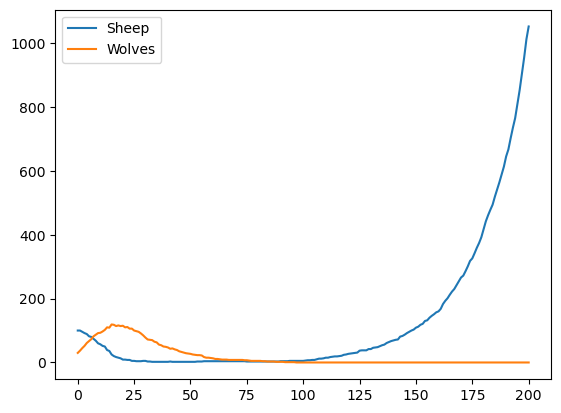

In [23]:
%matplotlib inline
model = WolfSheep()
model.run_model()
data = model.datacollector.get_model_vars_dataframe()
_ = data.plot()

However, these models are not deterministic and there might be a strong dependence on initial conditions even if the rest of the parameters have the same values. This can influence the (temporal) behaviour of the model and the outputs you analyze. It is therefore important to run the model multiple times with the same parameter values and calculate averages and measures of spread instead of jumping to conclusions from single model runs. Below we run the model 5 times and then you can judge if the behaviour is similar in all runs.

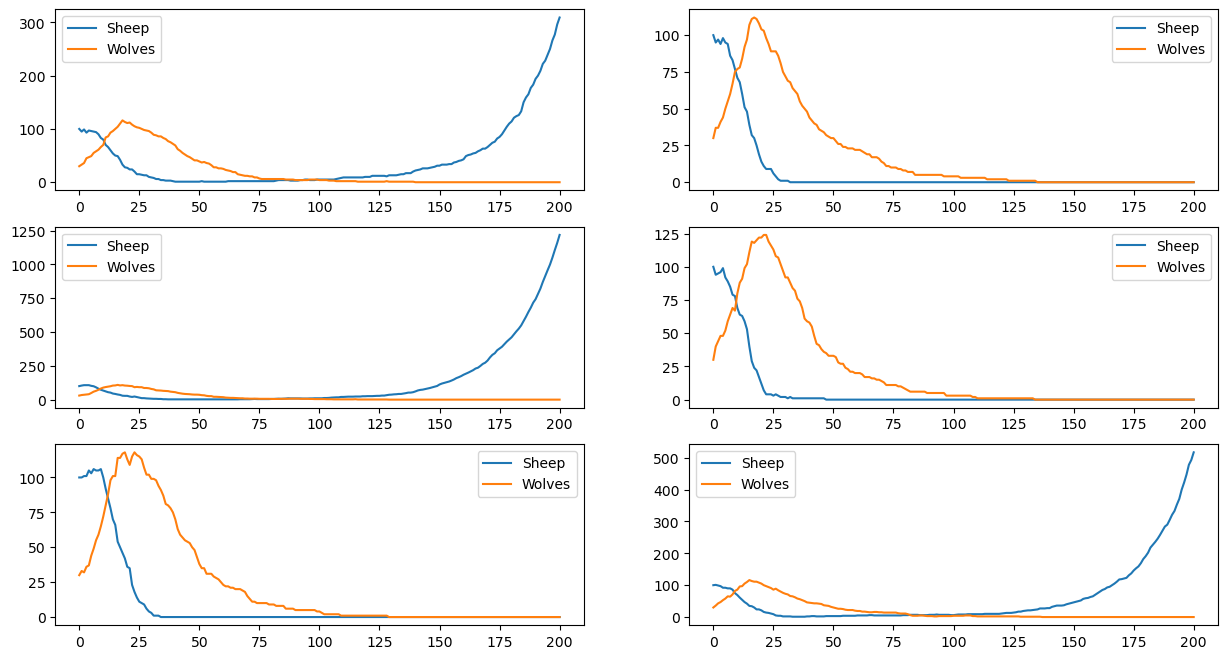

In [24]:
%matplotlib inline
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
axes = axes.flatten()
for i in range(6):
    model = WolfSheep()
    model.run_model()
    data = model.datacollector.get_model_vars_dataframe()
    _ = data.plot(ax=axes[i])

If you have time left, see if you can make a similar plot which displays the average number of sheep a wolf has eaten over its lifetime for each `step()` in the model. You will need to change the `step()` method of the wolf so that it counts every sheep it has eaten, and you will need to change the `DataCollector` to log this data. You can then use `model.datacollector.get_agent_vars_dataframe()` to get your data.

Take a look at the [Mesa Read The Docs](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html#collecting-data) for more details.

### Visualisation
Mesa provides you with an interactive visualisation toolkit. This is done through a local server that uses JavaScript to draw  everything in a browser window. An advantage of this is that we can run models step by step, spotting patterns, behaviors, bugs, developing new intuitions, hypotheses or insights. It is also a very good way to explain a model to your roommates or grandparents. Feel free to take a look and change elements to get accustomed to how the visualisation module works. For more information, visit [this link](https://mesa.readthedocs.io/en/latest/tutorials/visualization_tutorial.html#building-your-own-visualization-component). You can also visualise stuff yourself as the Mesa visualisation can be relatively limited in some use cases.

### Mesa best practices
To ensure that our models are easily accessible and maintainable, Mesa provides us with some general principles. These principles can be found [here](https://mesa.readthedocs.io/en/latest/best-practices.html), but the main take-away is that you should structure your files. The model class for example, should be located in `model.py` and generally, the agents should be located in `agent.py`.
